# Матрица доступности

- Тут вариант как-то собирать это все для контекста + сценария из дорог, но я пока не знаю, как. 
- Поэтому промежуточный вариант: матрица расстояний с переводом `метров` в `минуты`.

In [61]:
import geopandas as gpd
import pandas as pd

In [62]:
SCENARIO_ID = 1134

In [63]:
from prostor.fetchers import scenarios

PROJECT_ID = scenarios.get_scenario(SCENARIO_ID)['project']['project_id']
PROJECT_ID

73

## 1. Объединение кварталов контекста и сценария

Читаем кварталы контекста

In [64]:
context_blocks_gdf = pd.read_pickle('./data/context_blocks.pickle')
context_blocks_gdf['is_project'] = False
crs = context_blocks_gdf.crs

Читаем кварталы сценария

In [65]:
scenario_blocks_gdf = pd.read_pickle('./data/scenario_blocks.pickle').to_crs(crs)
scenario_blocks_gdf['is_project'] = True

Объединяем одно с другим

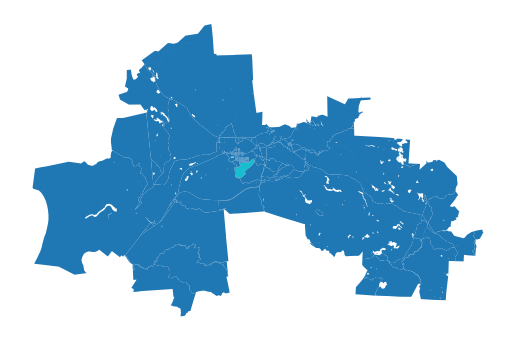

In [66]:
blocks_gdf = pd.concat([scenario_blocks_gdf, context_blocks_gdf]).reset_index(drop=True)
blocks_gdf.plot('is_project').set_axis_off()

## 2. Назначение доп параметров

### 2.1. Площадь

In [67]:
blocks_gdf['site_area'] = blocks_gdf.area

### 2.2. `territory_id` из контекста

Чтобы затем можно было фильтровать по ним в модулях при необходимости

In [68]:
from prostor.fetchers import projects, territories

def get_context_territories(project_id : int) -> gpd.GeoDataFrame:
    project = projects.get_project(project_id)
    context_ids = project['properties']['context']
    data = [{
        'territory_id': territory_id,
        'geometry': territories.get_territory_geometry(territory_id)
    } for territory_id in context_ids]
    gdf = gpd.GeoDataFrame(data=data, crs=4326)
    return gdf

context_territories_gdf = get_context_territories(PROJECT_ID)

In [69]:
from blocksnet.blocks.assignment import assign_objects

context_territories_gdf = context_territories_gdf.to_crs(blocks_gdf.crs)

assign_gdf = assign_objects(blocks_gdf, context_territories_gdf.rename(columns={'territory_id':'name'}))

In [70]:
assign_gdf.head()

,geometry,117,121,name,share
0,"POLYGON ((529877.655 6730826.811, 529893.716 6...",1.0,0.0,117,1.0
1,"POLYGON ((514082.763 6748141.067, 514089.492 6...",0.0,1.0,121,1.0
2,"POLYGON ((515263.383 6746701.026, 515186.738 6...",0.0,1.0,121,1.0
3,"POLYGON ((510869.045 6716062.596, 510777.195 6...",1.0,0.0,117,1.0
4,"POLYGON ((510568.584 6715681.701, 510684.369 6...",1.0,0.0,117,1.0


In [71]:
blocks_gdf['territory_id'] = assign_gdf['name'].astype(int)

## 3. Считаем матрицы

### 3.1. Матрица доступности

In [72]:
from blocksnet.relations import calculate_distance_matrix

SPEED = 5 * 1_000 / 60

def get_accessibility_matrix(blocks : gpd.GeoDataFrame) -> pd.DataFrame:
  crs = blocks.estimate_utm_crs()
  dist_mx = calculate_distance_matrix(blocks.to_crs(crs))
  return dist_mx // SPEED

In [73]:
acc_mx = get_accessibility_matrix(blocks_gdf)
acc_mx.head()

,0,1,2,3,4,5,6,7,8,9,...,451,452,453,454,455,456,457,458,459,460
0,0.0,189.0,189.0,344.0,294.0,182.0,237.0,57.0,51.0,47.0,...,307.0,308.0,315.0,322.0,323.0,320.0,324.0,315.0,281.0,307.0
1,189.0,0.0,121.0,249.0,299.0,239.0,233.0,192.0,198.0,202.0,...,489.0,487.0,482.0,487.0,488.0,482.0,485.0,483.0,451.0,469.0
2,189.0,121.0,0.0,370.0,401.0,317.0,334.0,154.0,165.0,172.0,...,438.0,433.0,411.0,416.0,416.0,408.0,411.0,414.0,385.0,396.0
3,344.0,249.0,370.0,0.0,161.0,222.0,147.0,383.0,384.0,384.0,...,637.0,641.0,658.0,665.0,666.0,664.0,668.0,658.0,624.0,651.0
4,294.0,299.0,401.0,161.0,0.0,115.0,66.0,348.0,344.0,341.0,...,539.0,547.0,578.0,585.0,586.0,589.0,591.0,577.0,544.0,576.0


### 3.2. Матрица расстояний

Считается несложно, пусть будет для буферов.

In [74]:
from blocksnet.relations import calculate_distance_matrix

dist_mx = calculate_distance_matrix(blocks_gdf)
dist_mx.head()

,0,1,2,3,4,5,6,7,8,9,...,451,452,453,454,455,456,457,458,459,460
0,0,15790,15756,28746,24527,15183,19760,4823,4275,3942,...,25640,25676,26307,26835,26926,26735,27002,26333,23480,25647
1,15790,0,10131,20808,24932,19938,19456,16010,16541,16898,...,40820,40660,40176,40663,40708,40219,40495,40309,37584,39157
2,15756,10131,0,30898,33426,26462,27852,12911,13763,14341,...,36564,36090,34310,34735,34733,34001,34271,34540,32094,33018
3,28746,20808,30898,0,13458,18532,12305,31989,32027,32036,...,53136,53460,54884,55419,55525,55414,55676,54869,52008,54329
4,24527,24932,33426,13458,0,9665,5576,29018,28683,28439,...,44996,45602,48233,48770,48915,49094,49330,48111,45341,48058


## Результат

- Объединенный слой кварталов сценария и контекста с доп столбцами:
    - `is_project : bool`
    - `site_area : float`
    - `territory_id : int`
- Матрицу доступности в `минутах`.
- Матрица расстояний в `метрах`.

In [75]:
blocks_gdf.to_pickle('./data/blocks.pickle')
acc_mx.to_pickle('./data/acc_mx.pickle')
dist_mx.to_pickle('./data/dist_mx.pickle')